In [59]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import nonlinear_QM_FPJPA as Fs
import wx_programs as wx
import bnc
from generator import *
from hardware_config import *
from values import *
from qubit_class import *
import daq.daq_programs_homo as daq
import standard_sequences.rabi as rabi
from analysis.analysis import *
import analysis.classifier as classifier

In [60]:
q1 = Qubit(q1_dict, readout_dict)
q2 = Qubit(q2_dict, readout_dict)
readout = Readout(readout_dict)
print(f"{q1}\n{q2}")
q1.ge_amp =0.2

Qubit(RO_LO_pwr=16, ro_freq=6.7275, IQ_angle=205, ro_amp=0.5, ef_time=78.05067663337411, ge_amp=1.2, RO_LO=6.6247, ge_time=52.35258023759522, qubit_id=q1, ROq3=6.583064, ro_dur=5000, ef_ssm=-0.255, ge_ssm=-0.11, ef_amp=1, ROIF=0.10280000000000022, qubit_thr=[-10000, -600])
Qubit(RO_LO_pwr=16, ro_freq=6.65555, IQ_angle=85, ro_amp=0.5, ef_time=None, ge_amp=1.2, RO_LO=6.6247, ge_time=40.15374412400174, qubit_id=q2, ROq3=6.583064, ro_dur=5000, ef_ssm=-0.224, ge_ssm=-0.152, ef_amp=1, ROIF=0.030850000000000044, qubit_thr=[-10000, 2500])


In [61]:
wx_addr = wx.get_wx_address()
main_directory = r"C:\Users\quantum1\Documents"
save_dir = rf"{main_directory}\Python Scripts\Important Blue Fridge Python Files\New\nonlinear_QM\data"
target_bnc_address_6 = "USB0::0x03EB::0xAFFF::411-433500000-0753::INSTR"
bnc.set_bnc_output(
    general_vals_dict["qubit_bnc"], power_dBm=13, bnc_addr=target_bnc_address_6
)

In [62]:
def run_rabi(q1: object, q2: object, general_vals_dict: dict,
                     num_steps: int, sweep_time: float, reps: int):
    """
    Runs a single instance of the geRabi experiment
    and processes the resulting IQ data to compute probabilities vs. time.
    
    Returns:
        df_prob (pd.DataFrame): A DataFrame whose index is the time (computed as 
                                np.linspace(0, sweep_time/1000, num_steps)) and which has
                                columns ['P_f', 'P_e', 'P_g'] corresponding to the probabilities
                                of the f, e, and g states respectively.
    """
    # Run the experiment
    rabi.rabi_ge(q1, q2, general_vals_dict, num_steps, sweep_time)
    wx.wx_set_and_amplitude_and_offset(amp=general_vals_dict["wx_amps"],
                                       offset=general_vals_dict["wx_offs"])
    # Acquire the raw IQ data
    values = daq.run_daq_het_2q(q1, q2,
                                num_patterns=num_steps,
                                num_records_per_pattern=reps,
                                verbose=True)
    
    # Retrieve raw IQ data from the acquired values
    I1_raw = values.rec_readout_1[0]
    Q1_raw = values.rec_readout_1[1]
    I2_raw = values.rec_readout_2[0]
    Q2_raw = values.rec_readout_2[1]
    
    # Build a DataFrame from the IQ data for classification
    IQ_df = pd.DataFrame({
        "I1": I1_raw,
        "Q1": Q1_raw,
        "I2": I2_raw,
        "Q2": Q2_raw
    })
    return values, IQ_df
    # # Classify the IQ data (classifier.classify returns a DataFrame that has a 'predicted' column)
    # classified = classifier.classify(IQ_df)
    # states = classified['predicted']
    # # Reshape the predicted states.
    # # (Assume that classifier.reshape_for_exp returns an array of shape (num_steps, reps),
    # #  where each row corresponds to a time step and holds all the state measurements for that step.)
    # states_reshaped = classifier.reshape_for_exp(states, reps, num_steps)
    
    # # Initialize arrays to hold the probabilities vs. time.
    # P_f_time = np.zeros(num_steps)
    # P_e_time = np.zeros(num_steps)
    # P_g_time = np.zeros(num_steps)
    
    # # For each time step, calculate the probabilities.
    # for time_index, step_data in enumerate(states_reshaped):
    #     # step_data is (typically) a list/array of state measurements at this time step.
    #     prob_dict = classifier.probabilities(step_data)
    #     P_f_time[time_index] = prob_dict['P_f']
    #     P_e_time[time_index] = prob_dict['P_e']
    #     P_g_time[time_index] = prob_dict['P_g']
    
    # # Compute time values as the index for the DataFrame.
    # times = np.linspace(0, sweep_time/1000, num_steps)
    
    # # Build a DataFrame that holds the probability vs. time.
    # df_prob = pd.DataFrame({
    #     'P_f': P_f_time,
    #     'P_e': P_e_time,
    #     'P_g': P_g_time
    # }, index=times)
    
    # return  states, values

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 101
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
0, No error
0, No error
0, No error
0, No error
0, No error
Patterns: 101
Records per pattern: 500
Buffers per acquistion: 17
DAQ samples per pattern: 8192
0, No error
Capturing 17 buffers. Press <enter> to abort
Capture completed in 6.463035 sec
Captured 17 buffers (2.630343 buffers per sec)
Captured 52224 records (8080.414695 records per sec)
Transferred 855638016 bytes (132389514.370217 bytes per sec)


<Figure size 800x800 with 0 Axes>

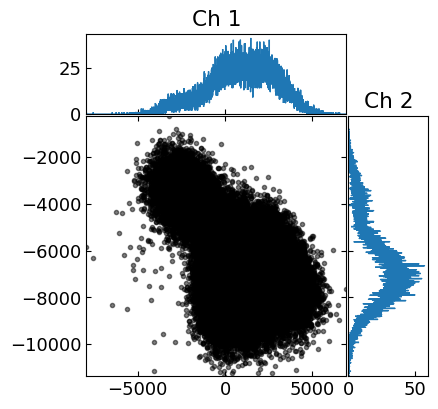

<Figure size 800x800 with 0 Axes>

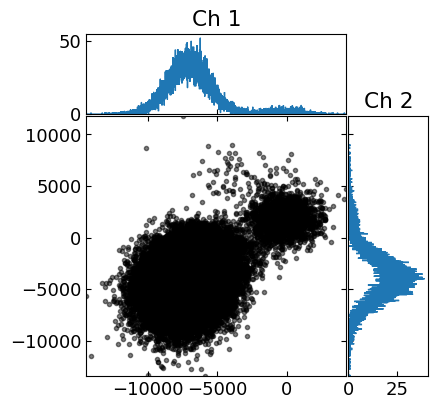

In [76]:
num_steps = 101
reps = 500
sweep_time=2000
values , IQ_df= run_rabi(q1, q2, general_vals_dict,num_steps, sweep_time,reps)

In [77]:
#Classify the IQ data (classifier.classify returns a DataFrame that has a 'predicted' column)
try:
    classified = classifier.classify(IQ_df)
finally:
    pass
states = classified['predicted']
# Reshape the predicted states.
# (Assume that classifier.reshape_for_exp returns an array of shape (num_steps, reps),
#  where each row corresponds to a time step and holds all the state measurements for that step.)
states_reshaped = classifier.reshape_for_exp(states, reps, num_steps)

In [79]:
P_g_new = []
P_e_new = []
P_f_new = []
for index, experiment in enumerate(states_reshaped):
    experiment = list(experiment)
    g_prob = experiment.count(0) / reps
    e_prob = experiment.count(1) / reps
    f_prob = experiment.count(2) / reps

    # data = classifier.probabilities(experiment)
    # print(data)
    P_g_new.append(g_prob)
    P_e_new.append(e_prob)
    P_f_new.append(f_prob)


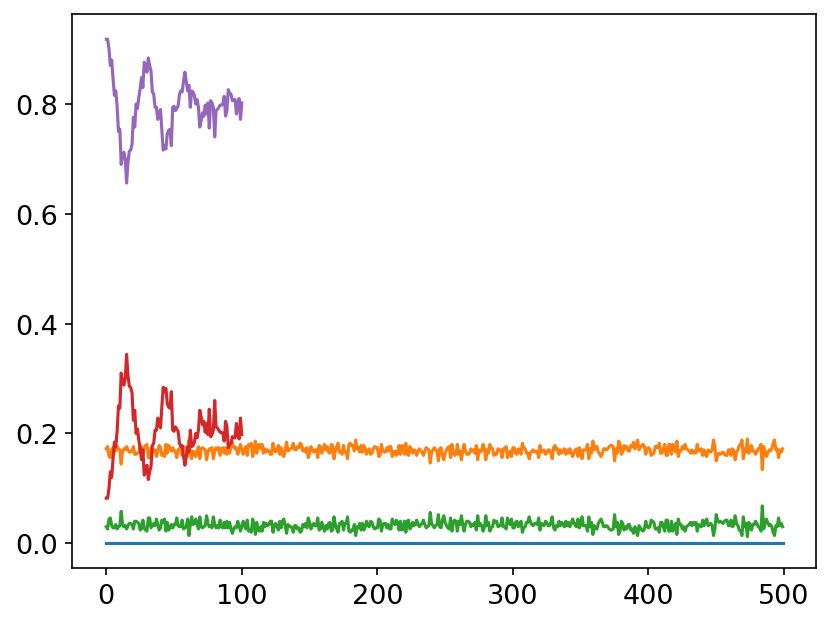

In [80]:
plt.figure(dpi =150)
plt.plot(P_g_new, label = 'g')
plt.plot(P_e_new, label = 'e')
plt.plot(P_f_new, label = 'f')
PQ1f = values.prob_vs_pats_1[1]
PQ2e = values.prob_vs_pats_1[0]
plt.plot(PQ1f)
plt.plot(PQ2e) 

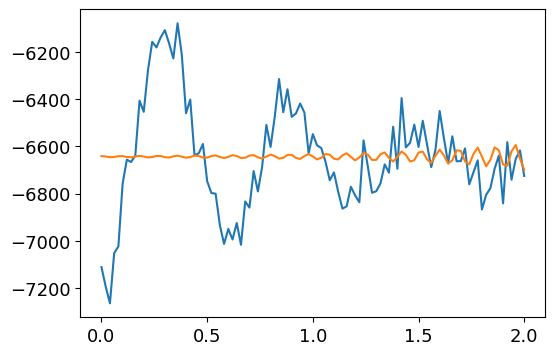



  freq: 11.264256682084692 +/- 0.7862071380720184
 gamma: -1.5621541114039719 +/- 4.771114857365651
   amp: -2.4146374564601842 +/- 19.948410518873995
 phase: -99.49409837875486 +/- 484.27972581400235
offset: -6643.415254620449 +/- 23.46643896455504
pi_pulse time: 0.044388193034985444 +/- 0.7862071380720184
π_ge time = 44.38819303498544 ns


In [81]:
which_qubit = 1
if 1 == which_qubit:
    I_Q1 = values.rec_avg_vs_pats_1[0]
    Q_Q1 = values.rec_avg_vs_pats_1[1]
    I = I_Q1
    Q = Q_Q1
elif 2 == which_qubit:
    I_Q2 = values.rec_avg_vs_pats_2[0]
    Q_Q2 = values.rec_avg_vs_pats_2[1]
    I = I_Q2
    Q = Q_Q2
Qrange = abs(np.max(Q)-np.min(Q))
Irange = abs(np.max(I)-np.min(I))
if Qrange>Irange:
    times = np.linspace(0,sweep_time/1000,num_steps)
    pi_ge_fit_vals,_,_,_ = fit_sine_decay(times,Q,guess_vals=[11,0.3,np.abs(np.max(Q)-np.min(Q)),38,Q[0]])
    pi_ge = abs((1/2/pi_ge_fit_vals[0])*1000)
    print("\u03C0_ge time = {} ns".format(pi_ge))
else:    
    times = np.linspace(0,sweep_time/1000,num_steps)
    pi_ge_fit_vals,_,_,_ = fit_sine_decay(times,I,guess_vals=[11,0.3,np.abs(np.max(I)-np.min(I)),38,I[0]])
    pi_ge = abs((1/2/pi_ge_fit_vals[0])*1000)
    print("\u03C0_ge time = {} ns".format(pi_ge))
    


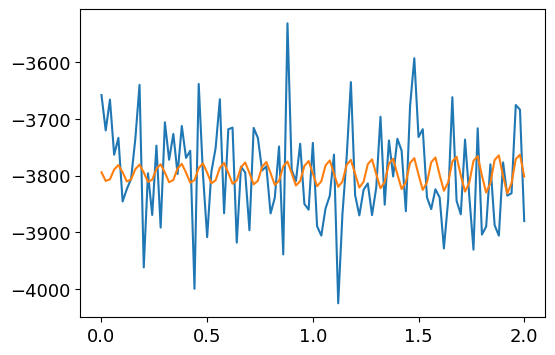



  freq: 10.023354066392166 +/- 0.14594180749823818
 gamma: -0.470742048507345 +/- 0.9460226935236864
   amp: 14.573267395216465 +/- 19.30168386754918
 phase: 531.5149518836892 +/- 74.3558223438062
offset: -3796.3692931999094 +/- 8.84783874999922
pi_pulse time: 0.04988350173885171 +/- 0.14594180749823818
π_ge time = 49.88350173885171 ns


In [82]:
which_qubit = 2
if 1 == which_qubit:
    I_Q1 = values.rec_avg_vs_pats_1[0]
    Q_Q1 = values.rec_avg_vs_pats_1[1]
    I = I_Q1
    Q = Q_Q1
elif 2 == which_qubit:
    I_Q2 = values.rec_avg_vs_pats_2[0]
    Q_Q2 = values.rec_avg_vs_pats_2[1]
    I = I_Q2
    Q = Q_Q2
Qrange = abs(np.max(Q)-np.min(Q))
Irange = abs(np.max(I)-np.min(I))
if Qrange>Irange:
    times = np.linspace(0,sweep_time/1000,num_steps)
    pi_ge_fit_vals,_,_,_ = fit_sine_decay(times,Q,guess_vals=[11,0.3,np.abs(np.max(Q)-np.min(Q)),38,Q[0]])
    pi_ge = abs((1/2/pi_ge_fit_vals[0])*1000)
    print("\u03C0_ge time = {} ns".format(pi_ge))
else:    
    times = np.linspace(0,sweep_time/1000,num_steps)
    pi_ge_fit_vals,_,_,_ = fit_sine_decay(times,I,guess_vals=[11,0.3,np.abs(np.max(I)-np.min(I)),38,I[0]])
    pi_ge = abs((1/2/pi_ge_fit_vals[0])*1000)
    print("\u03C0_ge time = {} ns".format(pi_ge))
    